# Using CellTypist for annotation-aware data integration
This notebook showcases how to perform single-cell data integration in a supervised manner using CellTypist.

Only the main steps and key parameters are introduced in this notebook. Refer to detailed [Usage](https://github.com/Teichlab/celltypist#usage-integration) if you want to learn more.

## Download and process four spleen datasets

In [1]:
import scanpy as sc

In [2]:
adata = sc.read('celltypist_demo_folder/Spleen.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Resources/Organ_atlas/Spleen/Spleen.h5ad')
adata

AnnData object with n_obs × n_vars = 200664 × 74369
    obs: 'Dataset', 'donor_id', 'development_stage', 'sex', 'suspension_type', 'assay', 'Original_annotation', 'CellTypist_harmonised_group', 'cell_type', 'Curated_annotation'
    var: 'exist_in_Madissoon2020', 'exist_in_Tabula2022', 'exist_in_DominguezConde2022', 'exist_in_He2020'
    uns: 'schema_version', 'title'
    obsm: 'X_umap'

This dataset combines cells from four studies, and is one of the [organ atlases](https://www.celltypist.org/organs) in CellTypist.

In [3]:
adata.obs.Dataset.value_counts()

Madissoon et al. 2020          92049
Dominguez Conde et al. 2022    70099
Tabula Sapiens 2022            34004
He et al. 2020                  4512
Name: Dataset, dtype: int64

Log-normalised gene expression (to 10,000 counts per cell) is in `.X`, and raw counts are in `.raw`. CellTypist does not rely on the latter, but here we still start from raw counts for completeness of a single-cell pipeline.

In [4]:
adata = adata.raw.to_adata()

Delete everything in the adata except `.X` and `.obs` for clarity of this tutorial.

In [5]:
del adata.var
del adata.uns
del adata.obsm
adata

AnnData object with n_obs × n_vars = 200664 × 74369
    obs: 'Dataset', 'donor_id', 'development_stage', 'sex', 'suspension_type', 'assay', 'Original_annotation', 'CellTypist_harmonised_group', 'cell_type', 'Curated_annotation'

Perform a canonical single-cell workflow from normalisation, highly variable genes (HVGs) identification, scaling, PCA, neighborhood construction to low-dimensional visualisation.

In [6]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, batch_key = 'Dataset', subset = True)
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


N.B.: Selection of HVGs is important for most single-cell tasks. Please find out the HVGs most suiting your data.

Visualise the dataset of origin (`Dataset`) and donor distribution (`donor_id`).

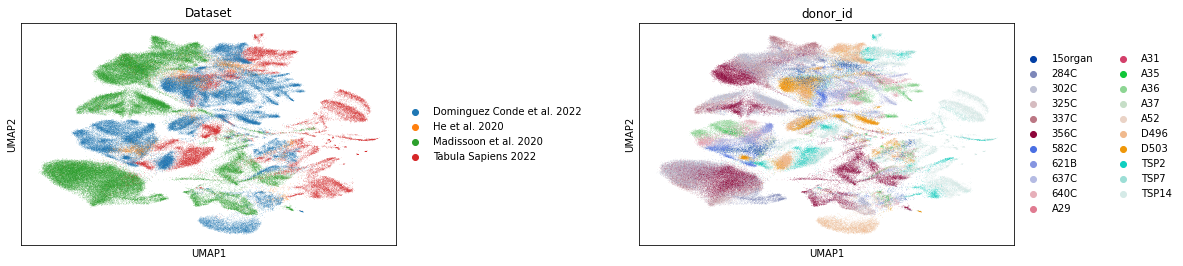

In [7]:
sc.pl.umap(adata, color = ['Dataset', 'donor_id'], wspace = 0.5)

As expected, strong batches exist.

## Data integration guided by ground truth

The input `AnnData` needs two columns in `.obs` representing the batch confounder and unified cell annotation respectively. The aim is to integrate cells by correcting batches and preserving biology (cell annotation) using [celltypist.integrate](https://celltypist.readthedocs.io/en/latest/celltypist.integrate.html).

Here we use `Dataset` as the batch confounder and `Curated_annotation` (ground-truth cell types) as the cell annotation.

In [8]:
import celltypist

In [9]:
# Integrate cells with `celltypist.integrate`.
celltypist.integrate(adata, 'Dataset', 'Curated_annotation')

👀 `use_rep` is not specified, will use `'X_pca'` as the search space


With this function, CellTypist will build the neighborhood graph by searching neighbors across matched cell groups in different batches, on the basis of a low-dimensional representation provided via the argument `use_rep` (default to PCA coordinates).

Generate a UMAP based on the reconstructed neighborhood graph.

In [10]:
sc.tl.umap(adata)

Visualise the batches.

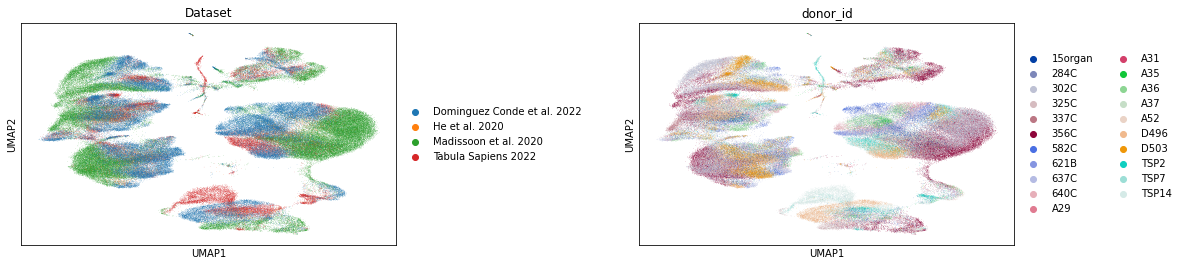

In [11]:
sc.pl.umap(adata, color = ['Dataset', 'donor_id'], wspace = 0.5)

Visualise the cell types.

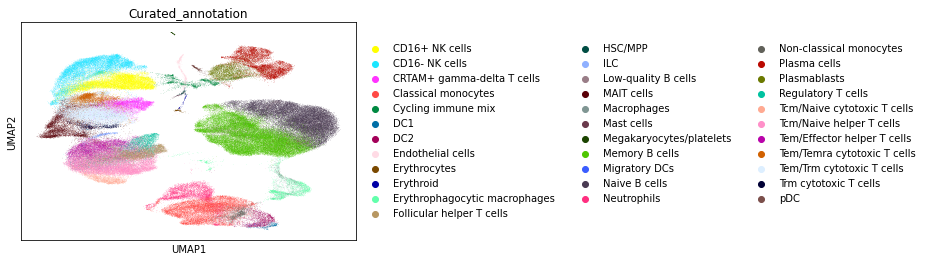

In [12]:
sc.pl.umap(adata, color = 'Curated_annotation')

Alternatively, use the `donor_id` rather than `Dataset` as the batch confounder.

In [13]:
celltypist.integrate(adata, 'donor_id', 'Curated_annotation')
sc.tl.umap(adata)

👀 `use_rep` is not specified, will use `'X_pca'` as the search space


Visualise the batches.

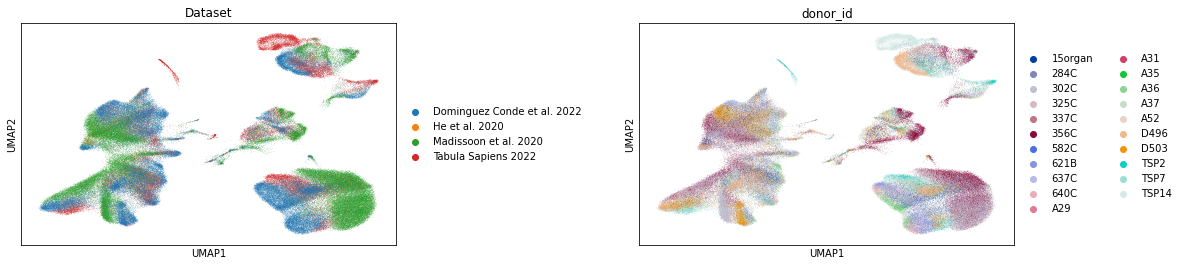

In [14]:
sc.pl.umap(adata, color = ['Dataset', 'donor_id'], wspace = 0.5)

Visualise the cell types.

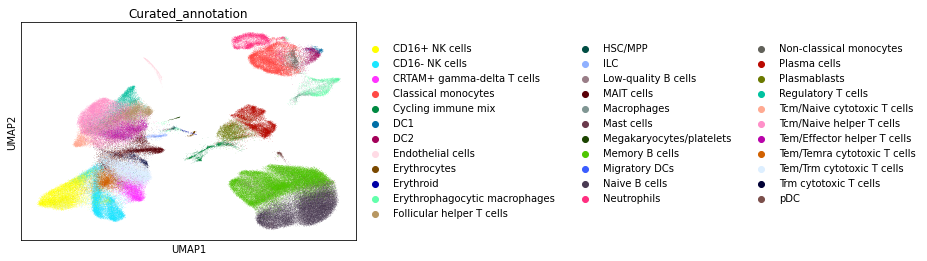

In [15]:
sc.pl.umap(adata, color = 'Curated_annotation')

Therefore, CellTypist is able to tune the data structure towards predetermined cell types while in the meantime mitigate the effects from batch confounders.

Of note, influence of cell annotation on the data structure can range from forcibly merging the same cell types to a more lenient cell grouping. This is achieved by adjusting the parameter `n_meta_neighbors`.  
  
With `n_meta_neighbors` of 1, each cell type only has one neighboring cell type, that is, itself. This will result in strongly separated cell types in the final UMAP.

In [16]:
celltypist.integrate(adata, 'donor_id', 'Curated_annotation', n_meta_neighbors = 1)
sc.tl.umap(adata)

👀 `use_rep` is not specified, will use `'X_pca'` as the search space


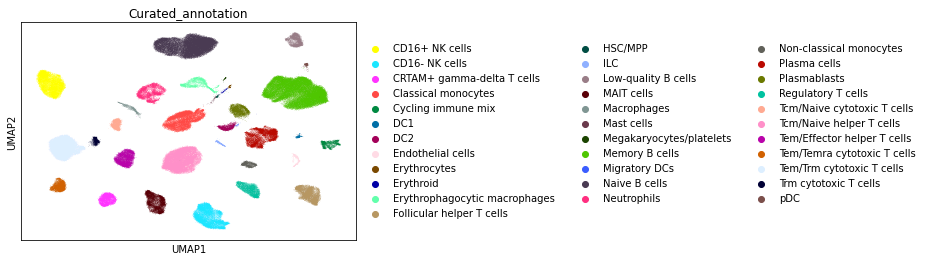

In [17]:
sc.pl.umap(adata, color = 'Curated_annotation')

Increasing `n_meta_neighbors` will loosen this restriction. For example, a `n_meta_neighbors` of 2 allows each cell type to have, in addition to itself, one nearest neighboring cell type based on the transcriptomic distances calculated by CellTypist. This parameter defaults to 3, meaning that a linear spectrum of transcriptomic structure can possibly exist for each cell type.

In [18]:
# Not run, as the default value of `n_meta_neighbors` is 3.
#celltypist.integrate(adata, 'donor_id', 'Curated_annotation', n_meta_neighbors = 3)
#sc.tl.umap(adata)

Ground-truth annotation is usually _not_ available when you collect a number of datasets and simply concatenate them. The sections below demonstrate two approaches to obtain cell annotations for use in `celltypist.integrate`.

## Data integration guided by CellTypist classification

`celltypist.integrate` requires cell annotation to be stored in the AnnData. This information can be obtained by different means. One quick way is to use available CellTypist models to annotate the data of interest (see the CellTypist model list [here](https://www.celltypist.org/models)).

Here we annotate the data with the `Immune_All_Low.pkl` model as the spleen is a major lymphoid organ. Find out how to conduct automatic CellTypist classification [here](https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb).

In [19]:
adata = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True).to_adata()

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will try the `.raw` attribute
🔬 Input data has 200664 cells and 74369 genes
🔗 Matching reference genes in the model
🧬 6632 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!


Through this function, three columns (`predicted_labels`, `majority_voting`, and `conf_score`) are appended to the `.obs` of the adata. You can also set `majority_voting = False` to decrease runtime, but will lose the `majority_voting` column.

In [20]:
adata.obs[['predicted_labels', 'majority_voting', 'conf_score']]

,predicted_labels,majority_voting,conf_score
AAACCTGCACATTTCT-1-HCATisStab7463846,MAIT cells,MAIT cells,0.996386
AAACCTGCACCGCTAG-1-HCATisStab7463846,CD16- NK cells,CD16- NK cells,0.990720
AAACCTGCAGTCCTTC-1-HCATisStab7463846,Tem/Trm cytotoxic T cells,Tem/Trm cytotoxic T cells,0.989506
AAACCTGCATTGGCGC-1-HCATisStab7463846,Memory B cells,Memory B cells,0.997790
AAACCTGCATTTCACT-1-HCATisStab7463846,CD16- NK cells,CD16- NK cells,0.996669
...,...,...,...
Spleen_cDNA_TTTGGTTTCGTCCAGG-1,Tem/Trm cytotoxic T cells,Tem/Trm cytotoxic T cells,0.294200
Spleen_cDNA_TTTGTCAAGGAGTTTA-1,Naive B cells,Naive B cells,0.999520
Spleen_cDNA_TTTGTCACAAGCGATG-1,CD16+ NK cells,CD16+ NK cells,0.999981
Spleen_cDNA_TTTGTCACAGGGATTG-1,CD16+ NK cells,CD16+ NK cells,0.091442


Integrate cells using `celltypist.integrate`, with `donor_id` as the batch confounder and `majority_voting` or `predicted_labels` as the cell annotation.

In [21]:
# You can also set 'predicted_labels' here in addition to 'majority_voting'.
celltypist.integrate(adata, 'donor_id', 'majority_voting')

👀 `use_rep` is not specified, will use `'X_pca'` as the search space


Generate a UMAP based on the reconstructed neighborhood graph.

In [22]:
sc.tl.umap(adata)

Visualise the batches.

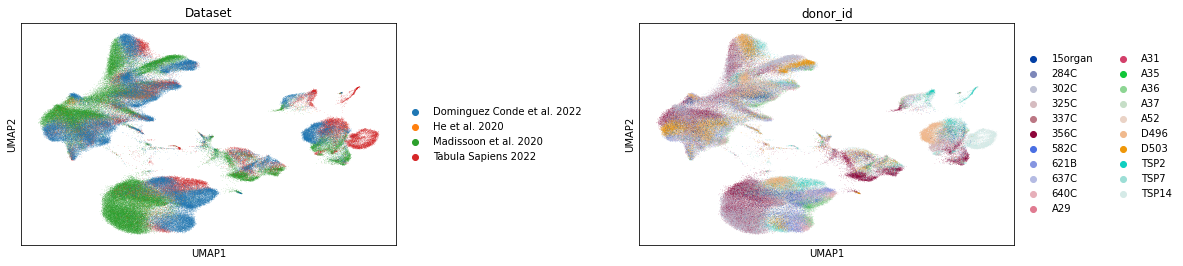

In [23]:
sc.pl.umap(adata, color = ['Dataset', 'donor_id'], wspace = 0.5)

Visualise the predicted cell types from CellTypist.

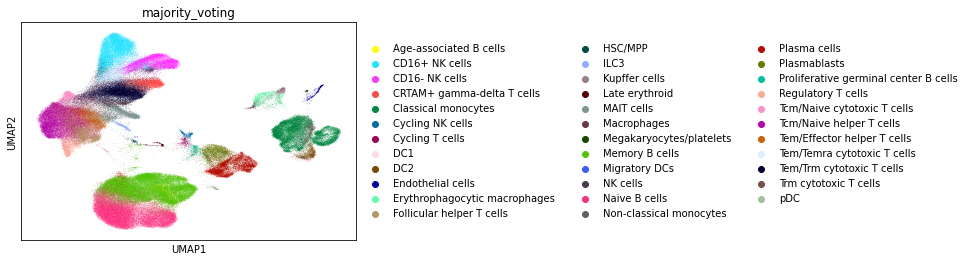

In [24]:
sc.pl.umap(adata, color = 'majority_voting')

Overlay the ground-truth annotations onto the UMAP.

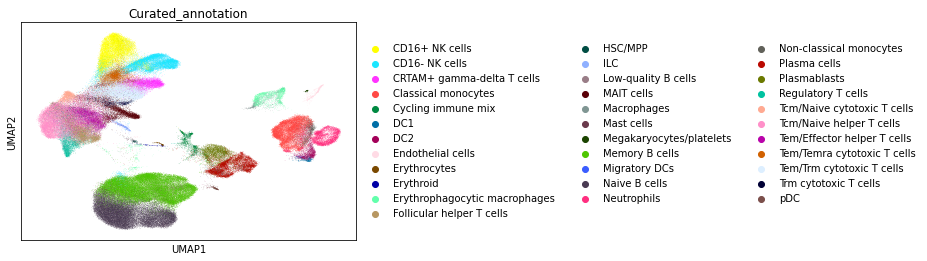

In [25]:
sc.pl.umap(adata, color = 'Curated_annotation')

Even the model does not exactly match the data (e.g., using a lung model to annotate a spleen data), this approach can be still useful as cells from the same cell type will probably be assigned the same identity by the model, therefore containing information with respect to which cells should be placed together in the neighborhood graph.

## Data integration guided by CellTypist harmonisation

In this section, we will harmonise cell types across datasets, and reannotate all cells into the harmonised cell types.

Cell type harmonisation is achieved through `celltypist.harmonize`. Refer to this [notebook](https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial_harmonisation.ipynb) for details.

In [26]:
alignment = celltypist.harmonize(adata, 'Dataset', 'Original_annotation')

👀 Detected PCA coordinates in the object, will use these to calculate distances
🏆 Reordering datasets
🖇 Harmonizing cell types of Dominguez Conde et al. 2022 and Madissoon et al. 2020
🖇 Harmonizing cell types of Tabula Sapiens 2022
🖇 Harmonizing cell types of He et al. 2020
🖋️ Reannotating cells
✅ Harmonization done!


Visualise the harmonisation result.

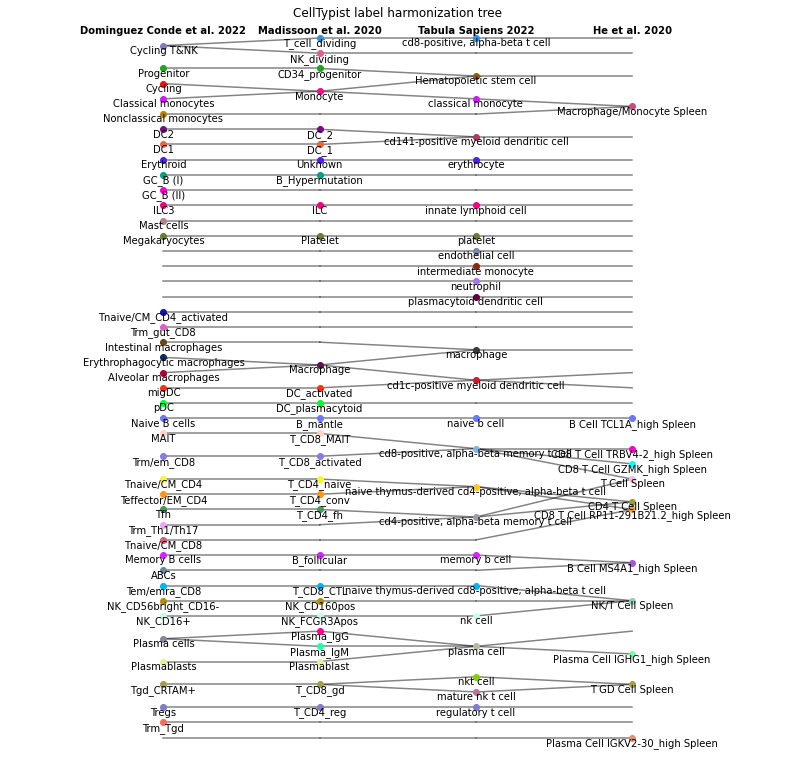

In [27]:
celltypist.treeplot(alignment)

This plot implies what cell types can be treated as counterparts during data integration.

Importantly, the cell reannotation information is stored as `alignment.reannotation`.

In [28]:
alignment.reannotation

,dataset,cell_type,reannotation,group
ID,,,,
AAACCTGCACATTTCT-1-HCATisStab7463846,Madissoon et al. 2020,T_CD8_MAIT,"MAIT = T_CD8_MAIT ∈ cd8-positive, alpha-beta m...",Group19
AAACCTGCACCGCTAG-1-HCATisStab7463846,Madissoon et al. 2020,NK_CD160pos,NK_CD56bright_CD16- = NK_CD160pos = UNRESOLVED...,Group21
AAACCTGCAGTCCTTC-1-HCATisStab7463846,Madissoon et al. 2020,T_CD8_activated,"Trm/em_CD8 = T_CD8_activated ∈ cd8-positive, a...",Group19
AAACCTGCATTGGCGC-1-HCATisStab7463846,Madissoon et al. 2020,B_mantle,Naive B cells = B_mantle = naive b cell = B Ce...,Group18
AAACCTGCATTTCACT-1-HCATisStab7463846,Madissoon et al. 2020,NK_CD160pos,NK_CD56bright_CD16- = NK_CD160pos = UNRESOLVED...,Group21
...,...,...,...,...
Spleen_cDNA_TTTGGTTTCGTCCAGG-1,He et al. 2020,CD8 T Cell TRBV4-2_high Spleen,"Trm/em_CD8 = T_CD8_activated ∈ cd8-positive, a...",Group19
Spleen_cDNA_TTTGTCAAGGAGTTTA-1,He et al. 2020,B Cell TCL1A_high Spleen,Naive B cells = B_mantle = naive b cell = B Ce...,Group18
Spleen_cDNA_TTTGTCACAAGCGATG-1,He et al. 2020,NK/T Cell Spleen,NK_CD16+ = NK_FCGR3Apos = nk cell ∈ NK/T Cell ...,Group21


The last two columns place __all__ cells under one naming schema. We will leverage them for supervised data integration.  
  
First, embed the two columns (`reannotation` and `group`) into the `obs` of the adata.

In [29]:
adata.obs[['reannotation', 'group']] = alignment.reannotation[['reannotation', 'group']].loc[adata.obs_names]

In [30]:
adata.obs.iloc[:, -2:]

,reannotation,group
AAACCTGCACATTTCT-1-HCATisStab7463846,"MAIT = T_CD8_MAIT ∈ cd8-positive, alpha-beta m...",Group19
AAACCTGCACCGCTAG-1-HCATisStab7463846,NK_CD56bright_CD16- = NK_CD160pos = UNRESOLVED...,Group21
AAACCTGCAGTCCTTC-1-HCATisStab7463846,"Trm/em_CD8 = T_CD8_activated ∈ cd8-positive, a...",Group19
AAACCTGCATTGGCGC-1-HCATisStab7463846,Naive B cells = B_mantle = naive b cell = B Ce...,Group18
AAACCTGCATTTCACT-1-HCATisStab7463846,NK_CD56bright_CD16- = NK_CD160pos = UNRESOLVED...,Group21
...,...,...
Spleen_cDNA_TTTGGTTTCGTCCAGG-1,"Trm/em_CD8 = T_CD8_activated ∈ cd8-positive, a...",Group19
Spleen_cDNA_TTTGTCAAGGAGTTTA-1,Naive B cells = B_mantle = naive b cell = B Ce...,Group18
Spleen_cDNA_TTTGTCACAAGCGATG-1,NK_CD16+ = NK_FCGR3Apos = nk cell ∈ NK/T Cell ...,Group21
Spleen_cDNA_TTTGTCACAGGGATTG-1,NK_CD16+ = NK_FCGR3Apos = nk cell ∈ NK/T Cell ...,Group21


Integrate cells using `celltypist.integrate`, with `donor_id` as the batch confounder and `reannotation` as the cell annotation.

In [31]:
celltypist.integrate(adata, 'donor_id', 'reannotation')

👀 `use_rep` is not specified, will use `'X_pca'` as the search space


In [32]:
sc.tl.umap(adata)

Visualise the batches.

... storing 'reannotation' as categorical
... storing 'group' as categorical


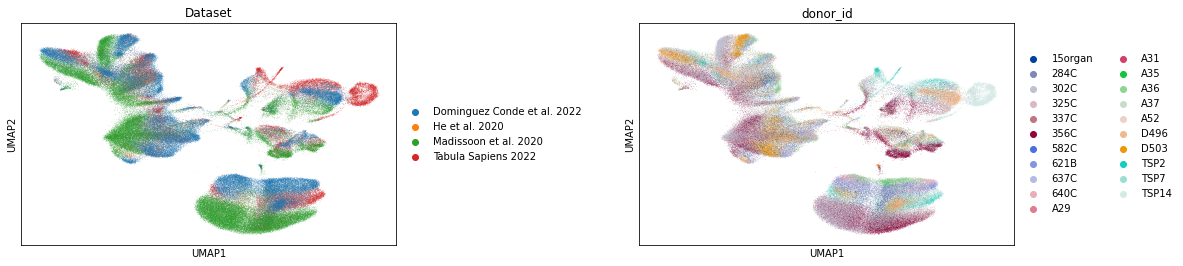

In [33]:
sc.pl.umap(adata, color = ['Dataset', 'donor_id'], wspace = 0.5)

Overlay the ground-truth annotations onto the UMAP.

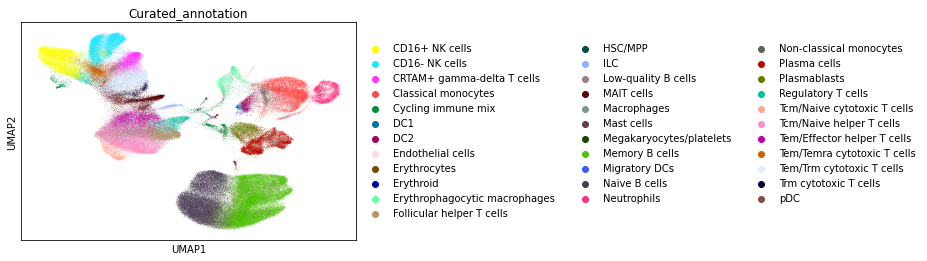

In [34]:
sc.pl.umap(adata, color = 'Curated_annotation')

Alternatively, you can set the `group` (i.e., high-hierarchy cell types) as the cell annotation.

In [35]:
celltypist.integrate(adata, 'donor_id', 'group')
sc.tl.umap(adata)

👀 `use_rep` is not specified, will use `'X_pca'` as the search space


Visualise the batches.

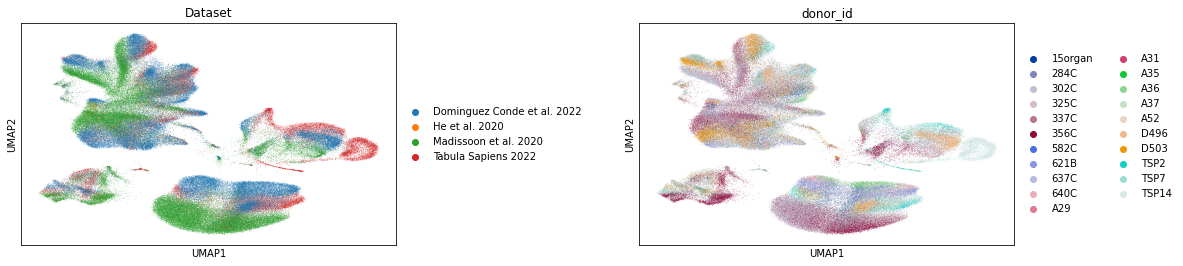

In [36]:
sc.pl.umap(adata, color = ['Dataset', 'donor_id'], wspace = 0.5)

Overlay the ground-truth annotations onto the UMAP.

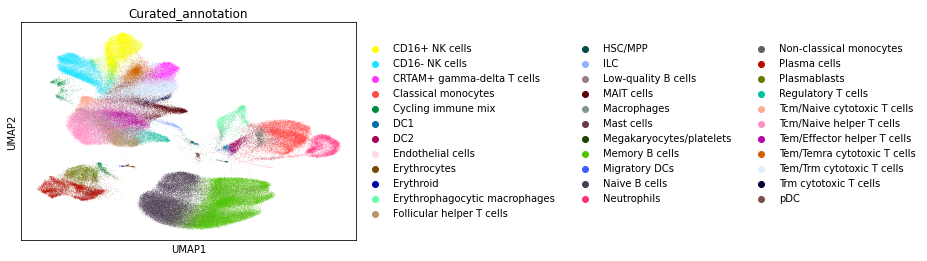

In [37]:
sc.pl.umap(adata, color = 'Curated_annotation')

Examine the distribution of high- and low-hierarchy cell types.

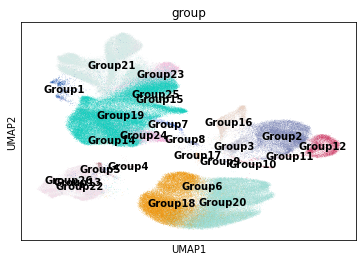

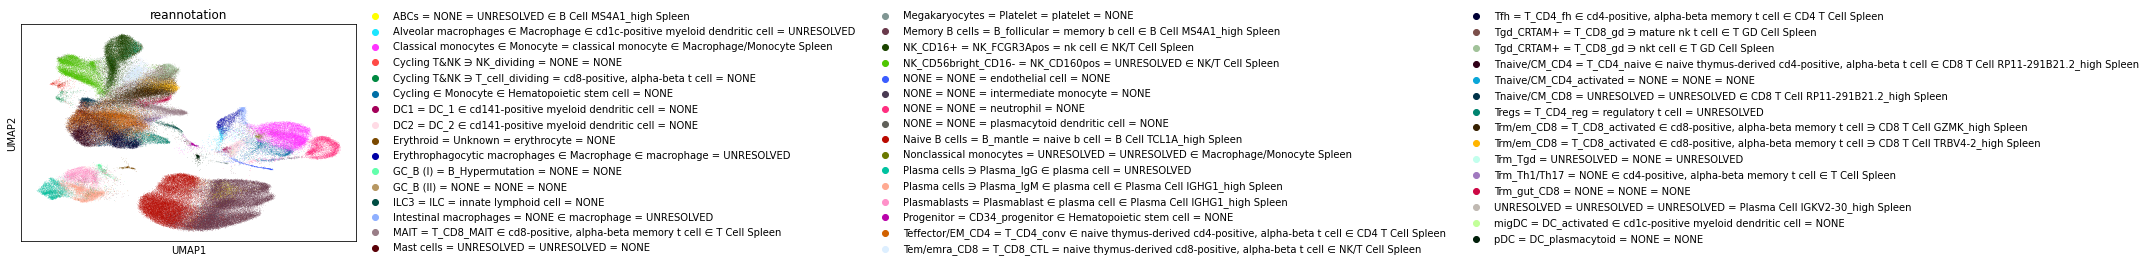

In [38]:
sc.pl.umap(adata, color = 'group', legend_loc = 'on data')
sc.pl.umap(adata, color = 'reannotation')

Lastly, as an example, we manually inspect some cell types.

Identify the components of a high-hierarchy cell type `Group21`.

In [39]:
alignment.relation[alignment.groups == 'Group21']

,Dominguez Conde et al. 2022,relation,Madissoon et al. 2020,relation,Tabula Sapiens 2022,relation,He et al. 2020
6,NK_CD16+,=,NK_FCGR3Apos,=,nk cell,∈,NK/T Cell Spleen
7,NK_CD56bright_CD16-,=,NK_CD160pos,=,UNRESOLVED,∈,NK/T Cell Spleen
8,Tem/emra_CD8,=,T_CD8_CTL,=,"naive thymus-derived cd8-positive, alpha-beta ...",∈,NK/T Cell Spleen


This table shows that three low-hierarchy cell types (corresponding to three rows) collectively constitute the high-hierarchy cell type `Group21`.

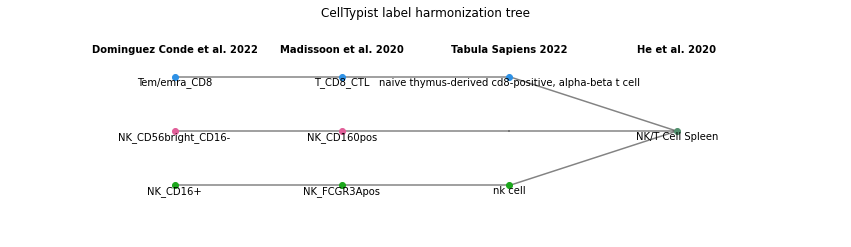

In [40]:
celltypist.treeplot(alignment.relation[alignment.groups == 'Group21'], figsize = [15, 4])

Find out the three low-hierarchy cell types.

In [41]:
import numpy as np
low_cell_types = np.unique(adata.obs.reannotation[adata.obs.group == 'Group21'])
low_cell_types

array(['NK_CD16+ = NK_FCGR3Apos = nk cell ∈ NK/T Cell Spleen',
       'NK_CD56bright_CD16- = NK_CD160pos = UNRESOLVED ∈ NK/T Cell Spleen',
       'Tem/emra_CD8 = T_CD8_CTL = naive thymus-derived cd8-positive, alpha-beta t cell ∈ NK/T Cell Spleen'],
      dtype=object)

Plot the distribution of the three cell types in the UMAP.

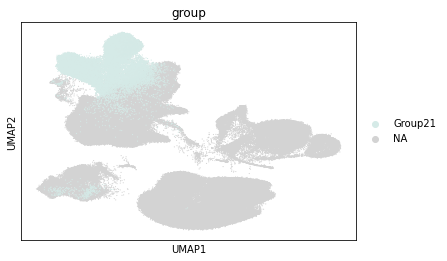

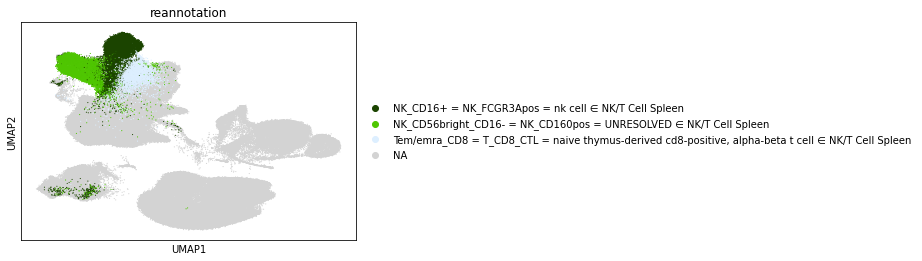

In [42]:
sc.pl.umap(adata, color = 'group', groups = 'Group21', size = 5)
sc.pl.umap(adata, color = 'reannotation', groups = list(low_cell_types), size = 5)